In [1]:
import os
import sys
import face_recognition
import re
import sklearn
import traceback
import numpy as np
import pickle
import pandas as pd

In [ ]:
# YALE B dataset
os.chdir('/home/huy/Downloads/face-dataset/YALE/faceonly/')

train_set = []
train_set_label = []

test_set = []
test_set_label = []

test_set_hm  = []
test_set_label_hm = []

test_file_ext = ['.glasses0.png', '.sleepy0.png', '.noglasses0.png', '.sad0.png']
test_file_ext_hm = ['.happy0.png', '.surprised0.png', '.wink0.png', '.leftlight0.png', '.rightlight0.png', '.centerlight0.png']

for entry in os.scandir('.'):
    if entry.is_dir() == True:
        label = re.findall('subject(.+)', entry.name)[0]
        if entry.name != 'subject15':
            train_set_label.append(label)
            image_filename = entry.name + '.normal0.png'
            image = face_recognition.load_image_file(os.path.join(entry.path, image_filename))
            encoded = face_recognition.face_encodings(image)[0]
            train_set.append(encoded)
        
        for ext in test_file_ext:
            img_filename = entry.name + ext
            img = face_recognition.load_image_file(os.path.join(entry.path, img_filename))
            encoded = face_recognition.face_encodings(img)[0]
            test_set.append(encoded)
            test_set_label.append(label)
        for ext in test_file_ext_hm:
            img_filename = entry.name + ext
            img = face_recognition.load_image_file(os.path.join(entry.path, img_filename))
            try:
                h, w, _ = img.shape
                roi = [(0,w,h,0)]
                encoded = face_recognition.face_encodings(img, known_face_locations=roi)[0]
            except :
                print(img_filename)
            test_set_hm.append(encoded)
            test_set_label_hm.append(label)

In [ ]:
# AT face dataset
os.chdir('/home/huy/Downloads/face-dataset/att_faces/orl_faces/')
train_set = []
train_set_label = []

test_set = []
test_set_label = []

test_set_hm  = []
test_label_hm = []

test_filename = [str(x) + '.pgm' for x in range(2,11)]
#test_file_ext_hm = ['.happy0.png', '.surprised0.png', '.wink0.png', '.leftlight0.png', '.rightlight0.png', '.centerlight0.png']


for entry in os.scandir('.'):
    if entry.is_dir() == True:
        label = re.findall('s(.+)', entry.name)[0]
        if entry.name not in ['s36', 's37', 's38', 's39', 's40'] :
            train_set_label.append(label)
            image_filename = '1.pgm'
            image = face_recognition.load_image_file(os.path.join(entry.path, image_filename))
            encoded = face_recognition.face_encodings(image)[0]
            train_set.append(encoded)
        
        for file in test_filename:
            if int(label) >= 36:
                label = '36'
            img = face_recognition.load_image_file(os.path.join(entry.path, file))
            try:
                h, w, _ = img.shape
                roi = [(0,w,h,0)]
                encoded = face_recognition.face_encodings(img, known_face_locations=roi)[0]
            except :
                print(img_filename)
            test_set.append(encoded)
            test_set_label.append(label)
#         for ext in test_file_ext_hm:
#             img_filename = entry.name + ext
#             img = face_recognition.load_image_file(os.path.join(entry.path, img_filename))
#             try:
#                 h, w, _ = img.shape
#                 roi = [(0,w,h,0)]
#                 encoded = face_recognition.face_encodings(img, known_face_locations=roi)[0]
#             except :
#                 print(img_filename)
#             test_set_hm.append(encoded)
#             test_label_hm.append(label)


In [ ]:
# COLOR FERET dataset
os.chdir('/home/huy/Downloads/face-dataset/colorferet/')

train_set = []
train_set_label = []
test_set = []
test_set_label = []

train_file_ext = ['fa']

test_file_ext = ['fb', 'fb_']

dataset_summary = {}

for entry in os.scandir('.'):
    train_sample_count = [0 for _ in range(len(train_file_ext))]
    file_count = len(os.listdir(entry.path))
    dataset_summary.update({entry.name : file_count})
    for file in os.scandir(entry.path):
        for i, ext in enumerate(train_file_ext):
            if int(entry.name) < 1000:
                if ext in file.name:
                    if train_sample_count[i] < 1:
                        try:
                            im = face_recognition.load_image_file(file.path)
                            encoded_face = face_recognition.face_encodings(im)[0]
                            train_set.append(encoded_face)
                            train_set_label.append(entry.name)
                        except:
                            print(file.name)
                    train_sample_count[i] += 1
        
#     if train_sample_count[0] == 0:
#         print(entry.name)
#     folder_count += 1
# print(count)
        
            
        for i, ext in enumerate(test_file_ext):
            if ext in file.name:
                im = face_recognition.load_image_file(file.path)
                try:
                    encoded_face = face_recognition.face_encodings(im)[0]
                    test_set.append(encoded_face)
                    if int(entry.name) < 1000:
                        test_set_label.append(entry.name)
                    else:
                        test_set_label.append('01000')
                except:
                    print(file.name)

In [ ]:
with open('feret_train.pickle', 'wb') as file:
    pickle.dump({'features':train_set, 'labels':train_set_label}, file)

In [ ]:
with open('feret_test.pickle', 'wb') as file:
    pickle.dump({'features':test_set, 'labels':test_set_label}, file)

In [ ]:
# COLOR FERET dataset
os.chdir('/home/huy/Downloads/face-dataset/colorferet/')
with open('feret_train.pickle', 'rb') as file:
    train_pickle = pickle.load(file)
    train_set = train_pickle['features']
    train_set_label = train_pickle['labels']
with open('feret_test.pickle', 'rb') as file:
    test_pickle = pickle.load(file)
    test_set = test_pickle['features']
    test_set_label = test_pickle['labels']

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

unknown_class_name = str(max([int(x) for x in train_label]) + 1)

def predict(model, sample, **hyperpara):
    raw = face_recognition.face_distance(model, sample)
    min_distance = np.amin(raw)
    min_index = np.argmin(raw)
    if min_distance > hyperpara['tolerance']:
        return unknown_class_name
    return train_set_label[min_index]

def evaluate_overall(tolerance=0.5, detail=False):
    test_pred = []
    number_of_sample = 0
    match = 0
    not_match = 0
    confusing = 0
    if detail == True: 
        
        for i, sample in enumerate(test_set):
            raw_result = face_recognition.compare_faces(train_set, sample, tolerance=tolerance)
            if raw_result.count(True) > 1:
                confusing += 1
            else:
                try:
                    index = raw_result.index(True)
                    if train_set_label[index] == test_label[i]:
                        match += 1
                    else:
                        not_match += 1
                except:
                    not_match += 1
            number_of_sample += 1
    else:
        for i, sample in enumerate(test_set):
            if predict(train_set, sample, tolerance=tolerance) == test_set_label[i]:
                match += 1
            else:
                not_match += 1
            number_of_sample += 1
    print('Number of samples: ', number_of_sample)
    print('Confusing: ', confusing)
    print('Match: ', match)
    print('Not match: ', not_match)
    return match/number_of_sample

test_pred = []
def evaluate_confusion_matrix(test_set, true_label, tolerance=0.5):
    for i, sample in enumerate(test_set):
        test_pred.append(predict(train_set, sample, tolerance=tolerance))
    return confusion_matrix(true_label, test_pred)

In [ ]:
evaluate_overall(0.6363636363636365)

In [ ]:
cfmx = evaluate_confusion_matrix(test_set, test_set_label, tolerance=0.525)
cfmx

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
print (sklearn.metrics.accuracy_score(test_set_label, test_pred))
print (sklearn.metrics.precision_score(test_set_label, test_pred, average='macro'))
print (sklearn.metrics.recall_score(test_set_label, test_pred, average='macro'))
print (sklearn.metrics.f1_score(test_set_label, test_pred, average='macro'))

In [ ]:
import numpy as np
max_acc = 0
good_tolerance = 0
for tolerance in np.linspace(0, 1, 100):
    acc = evaluate_overall(tolerance)
    if acc > max_acc:
        good_tolerance = tolerance
        max_acc = acc
print("Max acc: ", max_acc)
print("Tolerance: ", good_tolerance)

In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(test_set_label, test_pred, normalize=True)
plt.show()

Face Recognition Evaluation More Detail

In [ ]:
# AT&T Face database && FERET database
# Testing Model performance with different face poses.

attr id
center 0
halfleft 1
halfright 2
headup 3
headdown 4

In [14]:
# AT face dataset
os.chdir('/home/huy/Downloads/face-dataset/att_faces/orl_faces_labeled')

test_attr_labels = []

train_set = []
train_label = []

test_set = []
test_label = []

attr_labels = ['center', 'halfleft', 'halfright', 'headup', 'headdown']

class_number = 0

for entry in os.scandir('.'):
    if entry.is_dir():
        if len(entry.name) <= 3:
            enough_data = False
            for image_entry in os.scandir(entry.path):
                for index, value in enumerate(attr_labels):
                    if value in image_entry.name:
                        image = face_recognition.load_image_file(image_entry.path)
                        h, w, _ = image.shape
                        roi = [(0,w,h,0)]
                        encoded = face_recognition.face_encodings(image, known_face_locations=roi)[0]
                        if image_entry.name.startswith('center_1'):
                            if not enough_data:
                                train_set.append(encoded)
                                train_label.append(class_number)
                                enough_data = True
                        else:
                            test_set.append(encoded)
                            test_label.append(class_number)
                            test_attr_labels.append(index)
            class_number += 1

In [15]:
attr_group = []
for i,v in enumerate(test_attr_labels):
    if v not in [x[2] for x in attr_group]:
        attr_group.append([[test_set[i]], [test_label[i]], v])
    else:
        index = [x[2] for x in attr_group].index(v)
        attr_group[index][0].append(test_set[i])
        attr_group[index][1].append(test_label[i])

In [4]:
unknown_class_number = max([int(x) for x in train_label]) + 1
def predict(model, sample, **hyperpara):
    raw = face_recognition.face_distance(model, sample)
    min_distance = np.amin(raw)
    min_index = np.argmin(raw)
    if min_distance > hyperpara['tolerance']:
        return unknown_class_number
    return train_label[min_index]

def evaluate(test_set, true_label, tolerance=0.5):
    test_pred = []
    for i, sample in enumerate(test_set):
        test_pred.append(predict(train_set, sample, tolerance=tolerance))
    return test_pred

def evaluate_confusion_matrix(test_set, true_label, tolerance=0.5):
    for i, sample in enumerate(test_set):
        test_pred.append(predict(train_set, sample, tolerance=tolerance))
    return confusion_matrix(true_label, test_pred)

In [5]:
np.array(attr_group).shape

(5, 3)

In [16]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from pprint import pprint

In [ ]:
report = []
for i in range(0,1):
    test_pred = []
    test_set, test_label, _ = attr_group[i]
    test_pred = evaluate(test_set, test_label, 0.58)
    report.append(sklearn.metrics.classification_report(test_label, test_pred, output_dict=True))

In [17]:
def evaluate_acc(test_label, test_pred):
    max_class_number = max(test_pred)
    class_samples = [0 for i in range(0,max_class_number+1)]
    true_pred = [0 for i in range(0,max_class_number+1)]
    for i,v in enumerate(test_pred):
        try:
            if test_label[i] == v:
                true_pred[int(v)] += 1
            class_samples[int(v)] += 1
        except IndexError:
            print(i,v)
    return [x/y for x,y in zip(true_pred,class_samples) if y > 0]

In [24]:
std_accs = []
std_f1s = []
for i in range(0,5):
    test_label = attr_group[i][1]
    test_pred = []
    for index, sample in enumerate(attr_group[i][0]):
        test_pred.append(predict(train_set, sample, tolerance=0.58))
    report = sklearn.metrics.classification_report(test_label, test_pred, output_dict=True)
    f1s = []
    for label in range(0,31):
        if str(label) in report.keys():
            print(report[str(label)]['f1-score'])
            f1s.append(report[str(label)]['f1-score'])
    accs = evaluate_acc(test_label, test_pred)
    std_accs.append(np.std(accs))
    std_f1s.append(np.std(f1s))

1.0
1.0
1.0
0.6666666666666666
0.0
0.6666666666666666
0.0
1.0
1.0
0.0
0.8
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
1.0
1.0
0.6666666666666666
1.0
1.0
0.6666666666666666
1.0
0.0
1.0
1.0
1.0
0.6666666666666666
0.0
0.0
1.0
0.0
0.8000000000000002
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.7499999999999999
0.4
1.0
1.0
1.0
0.5714285714285715
1.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.6666666666666666
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.5
1.0


In [25]:
std_f1s

[0.3463720202761414,
 0.40055757337771797,
 0.3646422752776584,
 0.3666060555964672,
 0.4782600118020415]

In [26]:
std_accs

[0.28327886186626583,
 0.33290900012896,
 0.3142696805273545,
 0.28177133471338517,
 0.43229041164476456]

In [ ]:
import numpy as np
import sklearn.metrics
training_report = {
    'precision' : [],
    'recall' : [],
    'threshold' : []
}
def training():   
    max_f1_score = 0
    good_tolerance = 0
    for tolerance in np.linspace(0, 1, 500):
        test_pred = []
        for i, sample in enumerate(test_set):
            test_pred.append(predict(train_set, sample, tolerance=tolerance))
        f1_score = sklearn.metrics.f1_score(test_label, test_pred, average='macro')
        precision = sklearn.metrics.precision_score(test_label, test_pred, average='macro')
        recall = sklearn.metrics.recall_score(test_label, test_pred, average='macro')
        training_report['precision'].append(precision)
        training_report['recall'].append(recall)
        training_report['threshold'].append(tolerance)
        if f1_score > max_f1_score:
            good_tolerance = tolerance
            max_f1_score = f1_score
#     print("Max f1 score: ", max_f1_score)
#     print("Tolerance: ", good_tolerance)
    return good_tolerance

In [ ]:
training()

In [ ]:
df = pd.DataFrame(training_report)

In [ ]:
df

In [ ]:
df.to_excel("data.xlsx")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter
plt.style.use('grayscale')

# x = np.linspace(0,1, 100)
# spl1 = make_interp_spline(training_report['threshold'], training_report['precision'], k=9)
# spl2 = make_interp_spline(training_report['threshold'], training_report['recall'], k=9)
# y1 = spl1(x)
# y2 = spl2(x)
x = training_report['threshold']
y1 = savgol_filter(training_report['precision'], 51, 3)
y2 = savgol_filter(training_report['recall'], 51, 3)
line1 = plt.plot(x, y1, label='precision')
line2 = plt.plot(x, y2, label='recall')
plt.legend(loc='lower right')
plt.xlabel('threshold')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
for i in range(0,5):
    test_set = attr_group[i][0]
    test_label = attr_group[i][1]
    training()
    test_pred = []
    evaluate_confusion_matrix(test_set, test_label, good_tolerance);
    print(attr_labels[i])
    print('TOTAL: ', test_attr_labels.count(i))
    print ('ACC: ', sklearn.metrics.accuracy_score(test_label, test_pred))
    print ('PRECISION: ', sklearn.metrics.precision_score(test_label, test_pred, average='macro'))
    print ('RECALL: ', sklearn.metrics.recall_score(test_label, test_pred, average='macro'))
    print ('F1 SCORE: ', sklearn.metrics.f1_score(test_label, test_pred, average='macro'))

In [82]:
acc_scores = [85.18, 75.17, 90.32, 92.10, 76.47]
f1_scores = [80.00, 73.06, 82.45, 84.00, 60.42]
face_pose = ['Center', 'Half left', 'Half right', 'Head up', 'Head down']

In [83]:
x = list(zip(acc_scores, f1_scores, face_pose))

In [84]:
x

[(85.18, 80.0, 'Center'),
 (75.17, 73.06, 'Half left'),
 (90.32, 82.45, 'Half right'),
 (92.1, 84.0, 'Head up'),
 (76.47, 60.42, 'Head down')]

In [85]:
x.sort(key=lambda x: x[0])

In [87]:
acc_scores, f1_scores, face_pose = zip(*x)

(75.17, 76.47, 85.18, 90.32, 92.1)

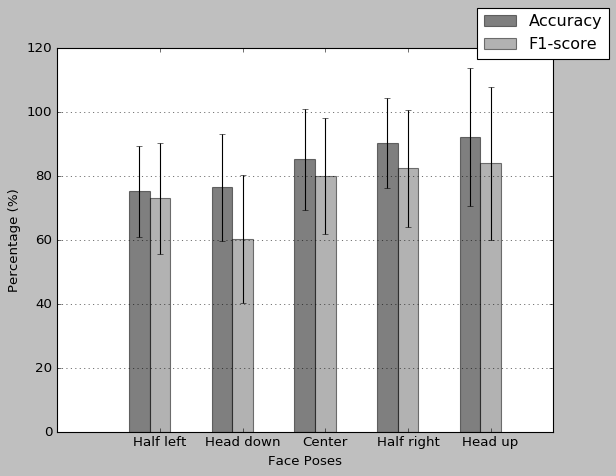

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
plt.style.use('classic')
plt.style.use('grayscale')


acc_std_percentage = [x*50 for x in std_accs]
f1_std_percentage = [x*50 for x in std_f1s]

fig, ax = plt.subplots()
bar_width = 0.25
x1 = np.arange(len(acc_scores))
x2 = [x + bar_width for x in x1]
ax.bar(x1, acc_scores, yerr=acc_std_percentage, width=bar_width, alpha=0.5 , label='Accuracy')
ax.bar(x2, f1_scores, yerr=f1_std_percentage, width=bar_width, alpha=0.5, label='F1-score')
ax.set_ylabel("Percentage (%)")
ax.set_xticks([r + bar_width for r in range(len(acc_scores))])
ax.set_xticklabels(face_pose)
ax.yaxis.grid(True)
ax.set_xlabel("Face Poses")
fig.legend()
plt.show()

In [33]:
np.arange(len(acc_scores))

range(0, 4)